In [121]:
import numpy as np
import math
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import seaborn as sns

Source time series manipulation: https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea

Source p-values: https://towardsdatascience.com/statistical-test-for-time-series-a57d9155d09b

Source forecasting: https://machinelearningmastery.com/make-sample-forecasts-arima-python/

## First we generate some non-stationary constantly increasing time-series

In [108]:
date_rng = pd.date_range(start='1/1/2018', end='1/25/2018', freq='H')
num = len(date_rng)
line = [ 2*x for x in list(range(num)) ]

In [109]:
data = pd.DataFrame(data=date_rng, columns=['date'])
data.set_index(['date'], inplace=True,)
data['val'] = line
data['noise'] = np.random.normal(0.5,9,num)
data['series'] = data['val'] + data['noise']
print(data.shape)

(577, 3)


## Clearly we see it is not stationary

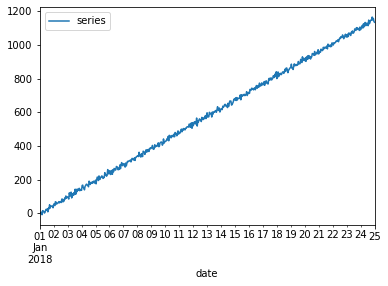

In [110]:
data.plot(y='series')

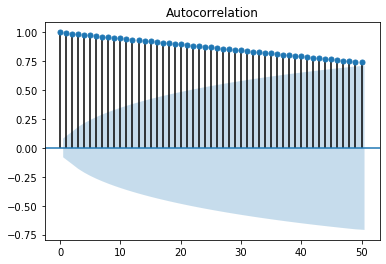

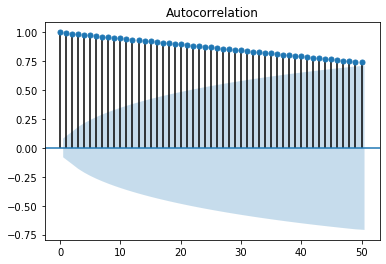

In [111]:
plot_acf(data['series'], lags=50)

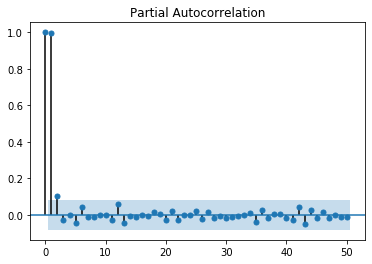

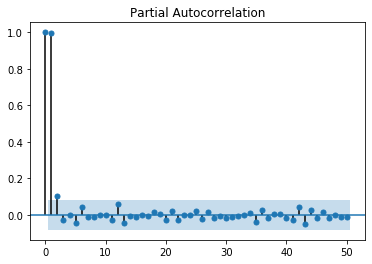

In [112]:
plot_pacf(data['series'], lags=50)

In [113]:
test = adfuller(data['series'])
print("Augmented Dickey Fuller, statistic {}, p-value {}, reject if > 0.05, has a root so is not stationary".format(test[0], test[1]))
if test[1] > 0.05:
    print("REJECT H0")
else:
    print("CANT REJECT H0")

Augmented Dickey Fuller, statistic -0.6092863440027534, p-value 0.8688698568106819, reject if > 0.05, has a root so is not stationary
REJECT H0


## Lets try differencing to get it stationary

In [114]:
data['series-diff'] = data['series'].diff()
data = data.dropna()
data.head(5)

,val,noise,series,series-diff
date,,,,
2018-01-01 01:00:00,2,1.178111,3.178111,5.951109
2018-01-01 02:00:00,4,-1.474431,2.525569,-0.652541
2018-01-01 03:00:00,6,0.794060,6.794060,4.268490
2018-01-01 04:00:00,8,-15.673241,-7.673241,-14.467301
2018-01-01 05:00:00,10,6.703138,16.703138,24.376380


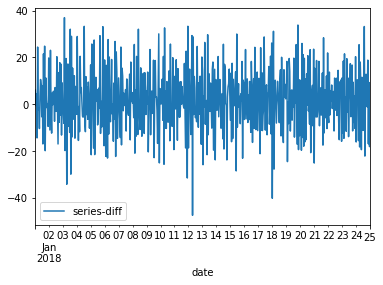

In [115]:
data.plot(y='series-diff')

In [116]:
test = adfuller(data['series-diff'])
print("Augmented Dickey Fuller, statistic {}, p-value {}, reject if > 0.05, has a root so is not stationary".format(test[0], test[1]))
if test[1] > 0.05:
    print("REJECT H0")
else:
    print("CANT REJECT H0")

Augmented Dickey Fuller, statistic -44.812226626655885, p-value 0.0, reject if > 0.05, has a root so is not stationary
CANT REJECT H0


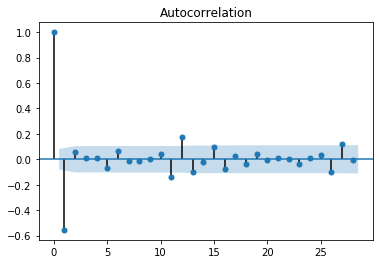

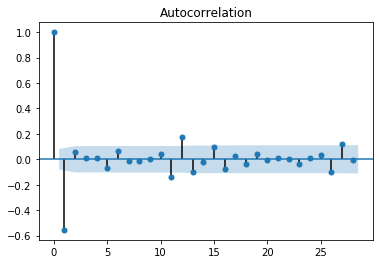

In [117]:
plot_acf(data['series-diff'])

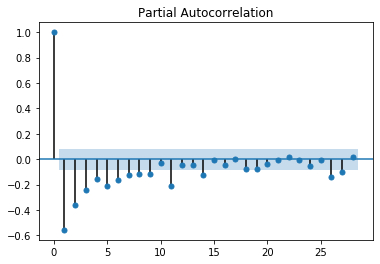

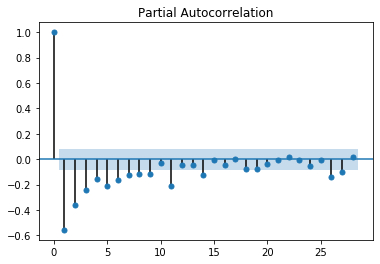

In [118]:
plot_pacf(data['series-diff'])

## Now we try to fit ARIMA model
First we try the simplest ignoring the pacf plot. We see from the p values, all components here are good. 

In [126]:
split = math.ceil(num*(2/3))
print(split)
training, validation = data[1:split], data[split:]
print("training: {}, validation: {}".format(training.shape, validation.shape))
training.head()

385
training: (384, 4), validation: (191, 4)


,val,noise,series,series-diff
date,,,,
2018-01-01 02:00:00,4,-1.474431,2.525569,-0.652541
2018-01-01 03:00:00,6,0.794060,6.794060,4.268490
2018-01-01 04:00:00,8,-15.673241,-7.673241,-14.467301
2018-01-01 05:00:00,10,6.703138,16.703138,24.376380
2018-01-01 06:00:00,12,2.107548,14.107548,-2.595590


In [129]:
model = ARIMA(training['series'], order=(1,1,0), dates=training.index, freq='H')

c:\users\benja\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [130]:
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 series   No. Observations:                  384
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1496.882
Date:                Sun, 17 Jan 2021   AIC                           2997.765
Time:                        14:09:09   BIC                           3005.661
Sample:                    01-01-2018   HQIC                          3000.897
                         - 01-17-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5074      0.046    -11.062      0.000      -0.597      -0.417
sigma2       145.1767     10.702     13.565      0.000     124.201     166.153
===================================================================================
Ljung-Box (Q):                      116.91   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.00   Prob(JB):                         0.88
Heteroskedasticity (H):               0.97   Skew:                             0.03
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Given the pacf lets try with MA(3) in there too. We see though that for MA.L2 and MA.L3 we have significant p values, so we think this may not be the best.

In [131]:
model2 = ARIMA(training['series'], order=(1,1,3), dates=training.index, freq='H')
fitted2 = model2.fit()
fitted2.summary()

c:\users\benja\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 series   No. Observations:                  384
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1402.050
Date:                Sun, 17 Jan 2021   AIC                           2814.099
Time:                        14:09:15   BIC                           2833.840
Sample:                    01-01-2018   HQIC                          2821.930
                         - 01-17-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   9.35e-06   1.07e+05      0.000       1.000       1.000
ma.L1         -2.1069      0.051    -41.415      0.000      -2.207      -2.007
ma.L2          1.2517      0.102     12.260      0.000       1.052       1.452
ma.L3         -0.1443      0.052     -2.758      0.006      -0.247      -0.042
sigma2        86.3182      6.891     12.527      0.000      72.813      99.823
===================================================================================
Ljung-Box (Q):                       45.51   Jarque-Bera (JB):                 2.31
Prob(Q):                              0.25   Prob(JB):                         0.31
Heteroskedasticity (H):               0.94   Skew:                            -0.08
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
model3 = ARIMA(training['series'], order=(1,1,2), dates=training.index, freq='H')
fitted3 = model3.fit()
fitted3.summary()

c:\users\benja\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 series   No. Observations:                  384
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1406.181
Date:                Sun, 17 Jan 2021   AIC                           2820.363
Time:                        14:09:26   BIC                           2836.155
Sample:                    01-01-2018   HQIC                          2826.627
                         - 01-17-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   5382.602      0.000       1.000       1.000
ma.L1         -1.9645      0.018   -110.433      0.000      -1.999      -1.930
ma.L2          0.9672      0.018     53.985      0.000       0.932       1.002
sigma2        88.5217      7.055     12.548      0.000      74.694     102.349
===================================================================================
Ljung-Box (Q):                       50.85   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.12   Prob(JB):                         0.40
Heteroskedasticity (H):               0.97   Skew:                            -0.08
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

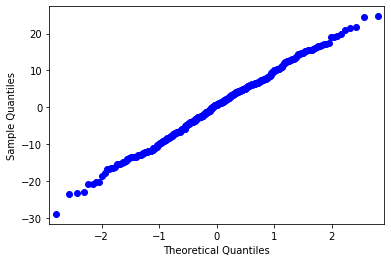

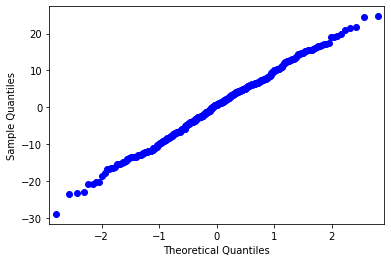

In [135]:
sm.qqplot(fitted3.resid)

## Use the forecast function to do out of sample forecasting

<ipython-input-157-7eae93990eb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predicted'] = fitted3.forecast(steps=len(validation))


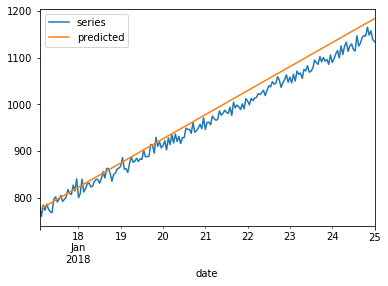

In [157]:
validation['predicted'] = fitted3.forecast(steps=len(validation))
validation.plot(y=['series', 'predicted'])

<ipython-input-160-d64bad07c32c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['error'] = (validation['series']-validation['predicted'])


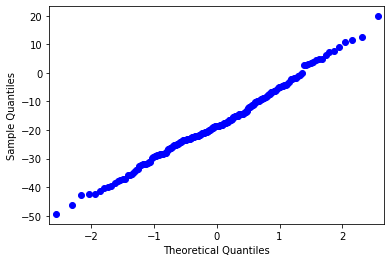

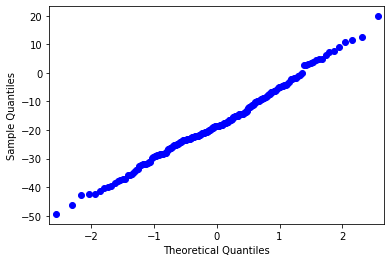

In [160]:
validation['error'] = (validation['series']-validation['predicted'])
sm.qqplot(validation['error'])

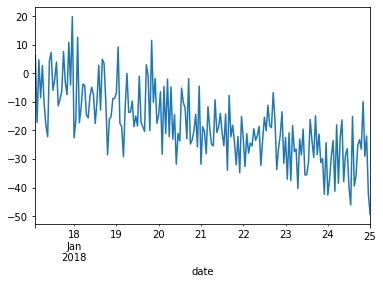

In [161]:
validation['error'].plot()